In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from scipy.stats import kurtosis
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.random_projection import GaussianRandomProjection

#### census data

In [2]:
census_path = '../Project 1/census/'

In [3]:
with open(os.path.join(census_path, 'adult.names')) as f:
    names = f.readlines()
cols = [c for c in names if c[0] != '|']
cols = [c.replace('\n', '') for c in cols]
cols = [c.split(':')[0] for c in cols]
cols = [c for c in cols if c]
cols = cols[1:] + [cols[0]]
df_census = pd.read_csv(os.path.join(census_path, 'adult.data'), names=cols)

In [4]:
X_census_cols = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',
    'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'
]
categorical_cols = [
    'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'
]
X_census = pd.get_dummies(df_census[X_census_cols], columns=categorical_cols, drop_first=True)
y_census = df_census['>50K, <=50K.'].map(lambda x: {'>50K': 1, '<=50K': 0}.get(x.strip()))

In [5]:
X_census_train, X_census_test, y_census_train, y_census_test = train_test_split(
    X_census, y_census, stratify=y_census, train_size=.8, shuffle=True, random_state=42
)

In [6]:
ss = StandardScaler()
x_cols = X_census.columns
X_census_train = ss.fit_transform(X_census_train)
X_census_test = ss.transform(X_census_test)

#### spam data

In [7]:
spam_path = '../Project 1/spam/'

In [8]:
with open(os.path.join(spam_path, 'spambase.names')) as f:
    names = f.readlines()
cols = [c for c in names if c[0] != '|']
cols = [c.replace('\n', '') for c in cols]
cols = [c.split(':')[0] for c in cols]
cols = [c for c in cols if c]
spam_cols = cols[1:]

In [9]:
df_spam = pd.read_csv(os.path.join(spam_path, 'spambase.data'), header=None)

In [10]:
X_spam_cols = df_spam.columns[:-1]
y_spam_col = df_spam.columns.difference(X_spam_cols)[0]
X_spam = df_spam[X_spam_cols]
y_spam = df_spam[y_spam_col]

In [11]:
X_spam_train, X_spam_test, y_spam_train, y_spam_test = train_test_split(
    X_spam, y_spam, stratify=y_spam, train_size=.8, shuffle=True, random_state=42
)

In [12]:
ss = StandardScaler()
x_cols = X_spam.columns
X_spam_train = ss.fit_transform(X_spam_train)
X_spam_test = ss.transform(X_spam_test)

#### visualize cluster

In [13]:
def viz_clusters(X, clusters, i=0, j=1):
    pca = PCA()
    x = pca.fit_transform(X)
    x1 = x[:, i]
    x2 = x[:, j]
    fig, ax = plt.subplots(figsize=(16,9))
    plot = ax.scatter(x1, x2, c=clusters, alpha=.2)
    var1 = round(pca.explained_variance_ratio_[i], 2)
    var2 = round(pca.explained_variance_ratio_[j], 2)
    ax.set_xlabel(f'PCA Component {i} - Percent Explained Variance {var1}')
    ax.set_ylabel(f'PCA Component {j} - Percent Explained Variance {var2}')
    leg = ax.legend(*plot.legend_elements())
    for lh in leg.legendHandles:
        lh._legmarker.set_alpha(1)

In [14]:
def elbow_plot(scores, metric, figsize=(5,3)):
    scores = pd.Series(scores)
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(scores.index, scores.values)
    ax.set_title('Elbow Plot')
    ax.set_ylabel(metric.title())
    ax.set_xlabel('K')

In [15]:
def calc_silhouette(d, c, alg):
    if alg == 'soft':
        n, m = c.shape
        scores = np.zeros(c.shape)
        for i in range(m):
            a = (d * c[:, i]).sum(axis=1) / np.dot(1-np.eye(n), c[:,i])
            b = np.zeros((n, m-1))
            for j in range(m):
                if i == j:
                    continue
                idx = j - (1 * (j > i))
                b[:, idx] = (d * c[:, j]).sum(axis=1) / np.dot(1-np.eye(n), c[:,j])
            b = b.min(axis=1)
            scores[:, i] = (b - a)/np.array([a, b]).max(axis=0)
        score = (scores * c).sum() / c.sum()
    elif alg == 'hard':
        if len(c.shape) > 1:
            if c.shape[1] > 1:
                c = c.argmax(axis=1)
            elif c.shape[1] == 1:
                c = c.reshape(-1)
        score = silhouette_score(d, c, metric='precomputed')
    return score

#### prep results

In [16]:
results = pd.DataFrame(index=range(4), columns=['method', 'k', 'reconstruction_error', 'avg_data_dist_error'])
choose_k_results = {}
idx = -1

#### PCA - census

In [17]:
X = X_census_train.copy()
y = y_census_train.copy()
X_val = X_census_test.copy()
cols = X_census.columns
model = PCA
idx += 1
method = 'pca'

In [18]:
results.loc[idx, 'method'] = method

In [19]:
# generate data
model_orig = model(random_state=4200)
X_pca = model_orig.fit_transform(X)

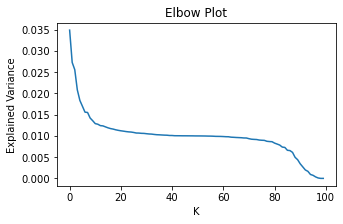

In [20]:
# choose k - explained variance
scores = {k: v for k, v in enumerate(model_orig.explained_variance_ratio_)}
choose_k_results['census_' + method] = scores
elbow_plot(scores, 'Explained Variance')

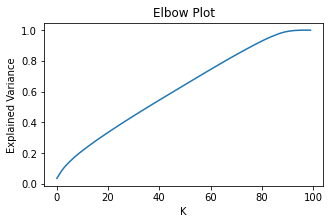

In [21]:
# choose k - cumulative explained variance
scores = {k: v for k, v in enumerate(model_orig.explained_variance_ratio_.cumsum())}
elbow_plot(scores, 'Explained Variance')

In [22]:
# choose k
k = 15
alt_k = 78
results.loc[idx, 'k'] = k

In [23]:
# evaluate - reconstruction error
model_lim = model(k, random_state=4200)
X_lim_pca = model_lim.fit_transform(X)
X_lim = model_lim.inverse_transform(X_lim_pca)
diff = X_lim - X
avg_data_error = ((diff ** 2).sum(axis=1) ** .5).mean()
reconstruction_error = (diff ** 2).sum() ** .5
results.loc[idx, 'avg_data_dist_error'] = avg_data_error
results.loc[idx, 'reconstruction_error'] = reconstruction_error
avg_data_error, reconstruction_error

(6.531725987902857, 1390.6027890757932)

In [24]:
model_alt_lim = model(alt_k, random_state=4200)
X_alt_lim_pca = model_alt_lim.fit_transform(X)
X_alt_lim = model_alt_lim.inverse_transform(X_alt_lim_pca)
alt_diff = X_alt_lim - X
avg_data_error = ((alt_diff ** 2).sum(axis=1) ** .5).mean()
reconstruction_error = (alt_diff ** 2).sum() ** .5
avg_data_error, reconstruction_error

(2.778806039386952, 502.90912186717816)

In [25]:
# evaluate - high weighted cols
pd.Series(abs(model_lim.components_).sum(axis=0), index=cols).sort_values(ascending=False).head(10)

education_ HS-grad               2.059485
sex_ Male                        1.837855
education_ Bachelors             1.824594
race_ Black                      1.802843
native-country_ Mexico           1.777935
relationship_ Own-child          1.765977
relationship_ Not-in-family      1.764173
native-country_ United-States    1.753283
workclass_ Local-gov             1.748639
relationship_ Wife               1.748296
dtype: float64

In [26]:
# evaluate - low weighted cols
pd.Series(abs(model_lim.components_).sum(axis=0), index=cols).sort_values(ascending=False).tail(10)

native-country_ Ireland       0.480162
native-country_ France        0.479415
native-country_ Honduras      0.473249
native-country_ Hong          0.471785
native-country_ Iran          0.462805
native-country_ Thailand      0.441684
workclass_ Without-pay        0.413858
workclass_ Never-worked       0.394487
native-country_ Yugoslavia    0.371739
native-country_ Hungary       0.317342
dtype: float64

In [27]:
# evaluate - low difference in weighted cols
(
    pd.Series(abs(model_lim.components_).sum(axis=0), index=cols) -
    pd.Series(abs(model_orig.components_).sum(axis=0), index=cols)
).abs().sort_values(ascending=False).tail(10)

workclass_ Private                    3.542388
race_ Black                           3.345420
education-num                         3.322374
marital-status_ Never-married         3.115515
age                                   3.097136
sex_ Male                             2.944743
marital-status_ Married-civ-spouse    2.813743
race_ White                           2.643437
native-country_ United-States         2.345815
race_ Asian-Pac-Islander              2.056042
dtype: float64

In [28]:
# evaluate - high difference in weighted cols
(
    pd.Series(abs(model_lim.components_).sum(axis=0), index=cols) -
    pd.Series(abs(model_orig.components_).sum(axis=0), index=cols)
).abs().sort_values(ascending=False).head(10)

native-country_ El-Salvador    6.763969
native-country_ Poland         6.719889
native-country_ Nicaragua      6.669161
native-country_ Ecuador        6.652708
native-country_ Hong           6.587500
native-country_ Jamaica        6.577056
native-country_ Laos           6.574549
native-country_ Italy          6.543509
native-country_ Puerto-Rico    6.536012
native-country_ Greece         6.528782
dtype: float64

In [29]:
# evaluate - high squared difference in reconstruction by col
pd.Series((diff ** 2).sum(axis=0), index=cols).abs().sort_values(ascending=False).head(10)

native-country_ Hungary       25674.630488
native-country_ Yugoslavia    25455.908101
workclass_ Never-worked       25392.579194
workclass_ Without-pay        25330.940374
native-country_ Iran          25207.271647
native-country_ Poland        25173.990371
native-country_ Thailand      25138.149852
native-country_ Ireland       25125.914693
native-country_ Honduras      25053.577011
native-country_ Hong          25032.099484
dtype: float64

In [30]:
# evaluate - low squared difference in reconstruction by col
pd.Series((diff ** 2).sum(axis=0), index=cols).abs().sort_values(ascending=False).tail(10)

sex_ Male                             7934.184367
education_ HS-grad                    7518.322161
marital-status_ Never-married         6412.009320
race_ Black                           6021.419001
race_ Asian-Pac-Islander              5329.854898
workclass_ Private                    4869.256523
native-country_ United-States         4187.597785
education-num                         3628.086393
race_ White                           3169.693935
marital-status_ Married-civ-spouse    2785.060109
dtype: float64

#### ICA - census

In [31]:
X = X_census_train.copy()
y = y_census_train.copy()
X_val = X_census_test.copy()
cols = X_census.columns
model = FastICA
idx += 1
method = 'ica'

In [32]:
results.loc[idx, 'method'] = method

In [33]:
# generate data
model_orig = model(max_iter=50000, random_state=4200)
X_ica = model_orig.fit_transform(X)

/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


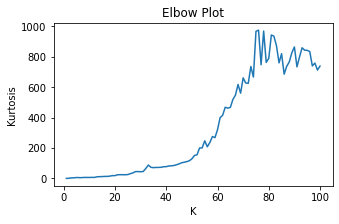

In [34]:
# choose k - kurtosis
scores = {}
for k in range(1, X.shape[1]+1):
    model_lim = model(k, max_iter=1000, random_state=4200)
    X_lim_ica = model_lim.fit_transform(X)
    scores[k] = abs(kurtosis(X_lim_ica)).mean()
choose_k_results['census_' + method] = scores
elbow_plot(scores, 'Kurtosis')

In [35]:
# choose k
k = 12
alt_k = 3
results.loc[idx, 'k'] = k

In [36]:
# evaluate - reconstruction error
model_lim = model(k, random_state=4200)
X_lim_ica = model_lim.fit_transform(X)
X_lim = model_lim.inverse_transform(X_lim_ica)
diff = X_lim - X
avg_data_error = ((diff ** 2).sum(axis=1) ** .5).mean()
reconstruction_error = (diff ** 2).sum() ** .5
results.loc[idx, 'avg_data_dist_error'] = avg_data_error
results.loc[idx, 'reconstruction_error'] = reconstruction_error
avg_data_error, reconstruction_error

(6.645106114108541, 1417.7458654383272)

In [37]:
model_alt_lim = model(alt_k, random_state=4200)
X_alt_lim_ica = model_alt_lim.fit_transform(X)
X_alt_lim = model_alt_lim.inverse_transform(X_alt_lim_ica)
alt_diff = X_alt_lim - X
avg_data_error = ((alt_diff ** 2).sum(axis=1) ** .5).mean()
reconstruction_error = (alt_diff ** 2).sum() ** .5
avg_data_error, reconstruction_error

(7.6621028213986655, 1541.5188282015595)

In [127]:
np.linalg.norm(X)

1613.9392801465883

In [39]:
# evaluate - high weighted cols
pd.Series(abs(model_lim.components_).sum(axis=0), index=cols).sort_values(ascending=False).head(10)

education_ HS-grad             0.008403
relationship_ Not-in-family    0.007640
education_ Some-college        0.006763
occupation_ Adm-clerical       0.006630
workclass_ Private             0.006612
occupation_ Craft-repair       0.006376
education-num                  0.005973
occupation_ Exec-managerial    0.005931
relationship_ Unmarried        0.005846
relationship_ Own-child        0.005784
dtype: float64

In [40]:
# evaluate - low weighted cols
pd.Series(abs(model_lim.components_).sum(axis=0), index=cols).sort_values(ascending=False).tail(10)

native-country_ Honduras                      0.000954
native-country_ Greece                        0.000939
native-country_ Yugoslavia                    0.000899
native-country_ Hungary                       0.000879
native-country_ Peru                          0.000855
native-country_ Portugal                      0.000841
native-country_ Outlying-US(Guam-USVI-etc)    0.000706
workclass_ Never-worked                       0.000681
native-country_ Scotland                      0.000554
native-country_ Holand-Netherlands            0.000257
dtype: float64

In [41]:
# evaluate - low difference in weighted cols
(
    pd.Series(abs(model_lim.components_).sum(axis=0), index=cols) -
    pd.Series(abs(model_orig.components_).sum(axis=0), index=cols)
).abs().sort_values(ascending=False).tail(10)

native-country_ Nicaragua     0.012728
native-country_ Thailand      0.012273
native-country_ Jamaica       0.011740
native-country_ Peru          0.011150
native-country_ Ireland       0.010444
native-country_ Yugoslavia    0.010161
native-country_ Canada        0.009721
native-country_ Haiti         0.009094
native-country_ Scotland      0.008674
hours-per-week                0.008445
dtype: float64

In [42]:
# evaluate - high difference in weighted cols
(
    pd.Series(abs(model_lim.components_).sum(axis=0), index=cols) -
    pd.Series(abs(model_orig.components_).sum(axis=0), index=cols)
).abs().sort_values(ascending=False).head(10)

education_ Bachelors          3.472957e+13
education-num                 3.465378e+13
education_ Masters            2.424398e+13
education_ Some-college       2.234707e+13
workclass_ Private            1.925068e+13
education_ HS-grad            1.880094e+13
education_ Prof-school        1.593652e+13
education_ Doctorate          1.498145e+13
education_ Assoc-acdm         1.451079e+13
occupation_ Prof-specialty    1.394517e+13
dtype: float64

In [43]:
# evaluate - high squared difference in reconstruction by col
pd.Series((diff ** 2).sum(axis=0), index=cols).abs().sort_values(ascending=False).head(10)

native-country_ Holand-Netherlands            26032.524144
native-country_ Scotland                      25941.193427
native-country_ Outlying-US(Guam-USVI-etc)    25933.785654
workclass_ Never-worked                       25911.811568
native-country_ Hungary                       25897.693222
native-country_ Yugoslavia                    25889.428972
native-country_ Honduras                      25869.272234
native-country_ Peru                          25845.333310
native-country_ Greece                        25842.593927
native-country_ Portugal                      25757.968603
dtype: float64

In [44]:
# evaluate - low squared difference in reconstruction by col
pd.Series((diff ** 2).sum(axis=0), index=cols).abs().sort_values(ascending=False).tail(10)

sex_ Male                             7533.284659
marital-status_ Never-married         5692.790639
education_ HS-grad                    5559.400609
native-country_ United-States         5122.067357
race_ Black                           5004.597339
workclass_ Private                    4328.709239
race_ Asian-Pac-Islander              4001.558605
education-num                         3470.753615
race_ White                           2826.535301
marital-status_ Married-civ-spouse    2784.870635
dtype: float64

#### random projections - census

In [45]:
X = X_census_train.copy()
y = y_census_train.copy()
X_val = X_census_test.copy()
cols = X_census.columns
model = GaussianRandomProjection
idx += 1
method = 'random projections'

In [46]:
results.loc[idx, 'method'] = method

In [47]:
# generate data
model_orig = model(X.shape[1], random_state=4200)
X_rp = model_orig.fit_transform(X)

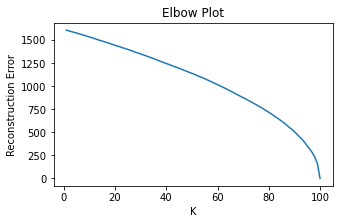

In [48]:
# choose k - reconstruction error
scores = {}
for k in range(1, X.shape[1]+1):
    W = model_orig.components_[:k].T
    X_rp_k = X.dot(W)
    W_inv = np.linalg.inv(W.T.dot(W)).dot(W.T)
    X_lim = X_rp_k.dot(W_inv)
    error = ((X_lim - X) ** 2).sum() ** .5
    scores[k] = error
choose_k_results['census_' + method] = scores
elbow_plot(scores, 'Reconstruction Error')

In [49]:
# choose k
k = 20
alt_k = 40
results.loc[idx, 'k'] = k

In [50]:
# evaluate - reconstruction error
model_lim = model(k, random_state=4200)
X_lim_rp = model_lim.fit_transform(X)
W_lim = model_lim.components_.T
W_lim_inv = np.linalg.inv(W_lim.T.dot(W_lim)).dot(W_lim.T)
X_lim = X_lim_rp.dot(W_lim_inv)
diff = X_lim - X
avg_data_error = ((diff ** 2).sum(axis=1) ** .5).mean()
reconstruction_error = (diff ** 2).sum() ** .5
results.loc[idx, 'avg_data_dist_error'] = avg_data_error
results.loc[idx, 'reconstruction_error'] = reconstruction_error
avg_data_error, reconstruction_error

(7.328976954277045, 1442.0755015143989)

In [51]:
model_alt_lim = model(alt_k, random_state=4200)
X_alt_lim_rp = model_alt_lim.fit_transform(X)
W_alt_lim = model_alt_lim.components_.T
W_alt_lim_inv = np.linalg.inv(W_alt_lim.T.dot(W_alt_lim)).dot(W_alt_lim.T)
X_alt_lim = X_alt_lim_rp.dot(W_alt_lim_inv)
alt_diff = X_alt_lim - X
avg_data_error = ((alt_diff ** 2).sum(axis=1) ** .5).mean()
reconstruction_error = (alt_diff ** 2).sum() ** .5
avg_data_error, reconstruction_error

(6.316183752685182, 1244.8345168576016)

In [52]:
# evaluate - model consistency
errors = []
for s in range(42, 42*10):
    model_s = model(k, random_state=s)
    X_s_rp = model_s.fit_transform(X)
    W_s = model_s.components_.T
    W_s_inv = np.linalg.inv(W_s.T.dot(W_s)).dot(W_s.T)
    X_s = X_s_rp.dot(W_s_inv)
    diff = X_s - X
    reconstruction_error = (diff ** 2).sum() ** .5
    errors.append(reconstruction_error)
errors = np.array(errors)
round(errors.mean(), 2), round(errors.std(), 2)

(1443.48, 2.57)

In [53]:
# evaluate - high weighted cols
pd.Series(abs(model_lim.components_).sum(axis=0), index=cols).sort_values(ascending=False).head(10)

native-country_ Trinadad&Tobago      5.547971
relationship_ Other-relative         4.976281
relationship_ Not-in-family          4.790421
native-country_ China                4.699748
sex_ Male                            4.599100
native-country_ India                4.589793
native-country_ Hungary              4.546299
education_ 12th                      4.411947
native-country_ Scotland             4.400377
marital-status_ Married-AF-spouse    4.355054
dtype: float64

In [54]:
# evaluate - low weighted cols
pd.Series(abs(model_lim.components_).sum(axis=0), index=cols).sort_values(ascending=False).tail(10)

native-country_ United-States    2.671915
race_ White                      2.609027
occupation_ Machine-op-inspct    2.558962
native-country_ Columbia         2.476480
education_ Bachelors             2.444490
native-country_ Iran             2.433819
native-country_ England          2.333920
native-country_ Hong             2.199784
native-country_ Laos             2.198907
workclass_ State-gov             1.959497
dtype: float64

In [55]:
# evaluate - low difference in weighted cols
(
    pd.Series(abs(model_lim.components_).sum(axis=0), index=cols) -
    pd.Series(abs(model_orig.components_).sum(axis=0), index=cols)
).abs().sort_values(ascending=False).tail(10)

native-country_ Guatemala          3.615401
native-country_ Taiwan             3.561515
native-country_ Honduras           3.533640
native-country_ South              3.504007
native-country_ Puerto-Rico        3.497281
marital-status_ Separated          3.410872
native-country_ Trinadad&Tobago    3.403579
native-country_ China              3.396653
native-country_ Hungary            3.387882
native-country_ Italy              3.029204
dtype: float64

In [56]:
# evaluate - high difference in weighted cols
(
    pd.Series(abs(model_lim.components_).sum(axis=0), index=cols) -
    pd.Series(abs(model_orig.components_).sum(axis=0), index=cols)
).abs().sort_values(ascending=False).head(10)

native-country_ Hong           6.204376
native-country_ Portugal       5.790005
race_ White                    5.758544
native-country_ El-Salvador    5.728236
occupation_ Adm-clerical       5.574985
native-country_ England        5.534859
education_ 7th-8th             5.516096
occupation_ Craft-repair       5.429049
race_ Asian-Pac-Islander       5.311615
hours-per-week                 5.223578
dtype: float64

In [57]:
# evaluate - high squared difference in reconstruction by col
pd.Series((diff ** 2).sum(axis=0), index=cols).abs().sort_values(ascending=False).head(10)

race_ Asian-Pac-Islander       24322.638163
native-country_ India          23912.498786
sex_ Male                      23632.296984
workclass_ Self-emp-not-inc    23605.839239
marital-status_ Separated      23528.344874
native-country_ China          23391.703450
race_ Other                    23346.572060
education_ 7th-8th             23283.407901
workclass_ Without-pay         23195.619609
hours-per-week                 22891.253767
dtype: float64

In [58]:
# evaluate - low squared difference in reconstruction by col
pd.Series((diff ** 2).sum(axis=0), index=cols).abs().sort_values(ascending=False).tail(10)

education_ Assoc-acdm            18842.593811
native-country_ Portugal         18630.602014
native-country_ England          18586.711327
education_ 5th-6th               18481.223456
native-country_ Scotland         18403.580286
native-country_ United-States    18045.877680
native-country_ Hong             17640.187368
native-country_ Guatemala        16980.083288
education_ Bachelors             16411.728183
race_ Black                      16038.457319
dtype: float64

#### random forest - census

In [59]:
X = X_census_train.copy()
y = y_census_train.copy()
X_val = X_census_test.copy()
y_val = y_census_test.copy()
cols = X_census.columns
model = RandomForestClassifier
params = {'max_depth': 5, 'random_state': 4200}
idx += 1
method = 'random forest'

In [60]:
results.loc[idx, 'method'] = method

In [61]:
# generate data
model_orig = model(100, **params)
X_rf = model_orig.fit(X, y)

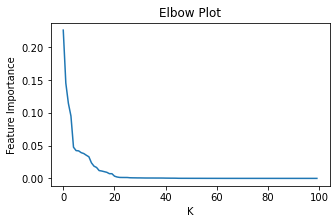

In [62]:
# choose k - feature importance
scores = {}
for k, v in enumerate(sorted(model_orig.feature_importances_, reverse=True)):
    scores[k] = v
choose_k_results['census_' + method] = scores
elbow_plot(scores, 'Feature Importance')

In [63]:
# choose k
k = 4
alt_k = 20
results.loc[idx, 'k'] = k
sorted_cols = sorted(zip(range(len(cols)), model_orig.feature_importances_), key=lambda x: x[1], reverse=True)
k_cols = [i for i, _ in sorted_cols[:k]]
alt_k_cols = [i for i, _ in sorted_cols[:alt_k]]

In [64]:
# evaluate - model validation
model_lim = model(100, **params)
model_lim.fit(X[:, k_cols], y)
model_lim.score(X_val[:, k_cols], y_val), model_orig.score(X_val, y_val)

(0.8479963150621833, 0.846307385229541)

In [65]:
model_alt_lim = model(X.shape[1], **params)
model_alt_lim.fit(X[:, alt_k_cols], y)
model_alt_lim.score(X_val[:, alt_k_cols], y_val)

0.8509135575003839

In [66]:
# evaluate - reconstruction error
X_lim = np.zeros(X.shape)
X_lim[:, k_cols] = X[:, k_cols]
diff = X_lim - X
avg_data_error = ((diff ** 2).sum(axis=1) ** .5).mean()
reconstruction_error = (diff ** 2).sum() ** .5
results.loc[idx, 'avg_data_dist_error'] = avg_data_error
results.loc[idx, 'reconstruction_error'] = reconstruction_error
avg_data_error, reconstruction_error

(7.940908063905215, 1581.331084877547)

In [67]:
X_alt_lim = np.zeros(X.shape)
X_alt_lim[:, alt_k_cols] = X[:, alt_k_cols]
alt_diff = X_alt_lim - X
avg_data_error = ((alt_diff ** 2).sum(axis=1) ** .5).mean()
reconstruction_error = (alt_diff ** 2).sum() ** .5
avg_data_error, reconstruction_error

(6.497063577668731, 1443.5511767859148)

In [68]:
# evaluate - high weighted cols
pd.DataFrame(
    [model_orig.feature_importances_[k_cols], model_lim.feature_importances_],
    columns=cols[k_cols],
    index=['orig_weight', 'lim_weight']
).T

,orig_weight,lim_weight
marital-status_ Married-civ-spouse,0.226520,0.409038
capital-gain,0.145622,0.289624
education-num,0.114690,0.256694
marital-status_ Never-married,0.095287,0.044644


#### save results

In [69]:
results.to_csv('./results/dr_census.csv', index=False)

#### prep results

In [70]:
results = pd.DataFrame(index=range(4), columns=['method', 'k', 'reconstruction_error', 'avg_data_dist_error'])
idx = -1

#### PCA - spam

In [71]:
X = X_spam_train.copy()
y = y_spam_train.copy()
X_val = X_spam_test.copy()
cols = spam_cols
model = PCA
idx += 1
method = 'pca'

In [72]:
results.loc[idx, 'method'] = method

In [73]:
# generate data
model_orig = model(random_state=4200)
X_pca = model_orig.fit_transform(X)

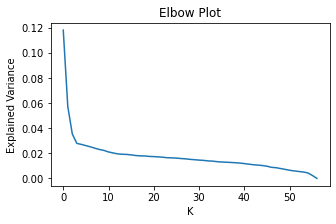

In [74]:
# choose k - explained variance
scores = {k: v for k, v in enumerate(model_orig.explained_variance_ratio_)}
choose_k_results['spam_' + method] = scores
elbow_plot(scores, 'Explained Variance')

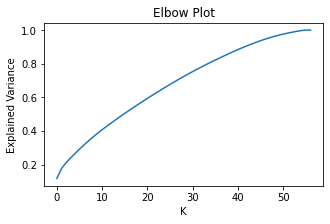

In [75]:
# choose k - cumulative explained variance
scores = {k: v for k, v in enumerate(model_orig.explained_variance_ratio_.cumsum())}
elbow_plot(scores, 'Explained Variance')

In [76]:
# choose k
k = 2
alt_k = 10
results.loc[idx, 'k'] = k

In [77]:
# evaluate - reconstruction error
model_lim = model(k, random_state=4200)
X_lim_pca = model_lim.fit_transform(X)
X_lim = model_lim.inverse_transform(X_lim_pca)
diff = X_lim - X
avg_data_error = ((diff ** 2).sum(axis=1) ** .5).mean()
reconstruction_error = (diff ** 2).sum() ** .5
results.loc[idx, 'avg_data_dist_error'] = avg_data_error
results.loc[idx, 'reconstruction_error'] = reconstruction_error
avg_data_error, reconstruction_error

(5.471869911436992, 415.8488117557937)

In [78]:
model_alt_lim = model(alt_k, random_state=4200)
X_alt_lim_pca = model_alt_lim.fit_transform(X)
X_alt_lim = model_alt_lim.inverse_transform(X_alt_lim_pca)
alt_diff = X_alt_lim - X
avg_data_error = ((alt_diff ** 2).sum(axis=1) ** .5).mean()
reconstruction_error = (alt_diff ** 2).sum() ** .5
avg_data_error, reconstruction_error

(4.728456835325276, 359.3657695240089)

In [79]:
# evaluate - high weighted cols
pd.Series(abs(model_lim.components_).sum(axis=0), index=cols).sort_values(ascending=False).head(10)

word_freq_direct        0.460174
word_freq_415           0.459442
word_freq_857           0.458985
word_freq_telnet        0.400963
word_freq_technology    0.389064
word_freq_labs          0.375077
word_freq_your          0.360367
word_freq_85            0.311987
word_freq_650           0.310454
word_freq_000           0.293888
dtype: float64

In [80]:
# evaluate - low weighted cols
pd.Series(abs(model_lim.components_).sum(axis=0), index=cols).sort_values(ascending=False).tail(10)

word_freq_project       0.075442
char_freq_[             0.062455
word_freq_conference    0.055631
char_freq_;             0.046296
char_freq_#             0.034497
word_freq_address       0.028124
word_freq_3d            0.022661
word_freq_font          0.020074
word_freq_parts         0.018705
word_freq_table         0.018301
dtype: float64

In [81]:
# evaluate - low difference in weighted cols
(
    pd.Series(abs(model_lim.components_).sum(axis=0), index=cols) -
    pd.Series(abs(model_orig.components_).sum(axis=0), index=cols)
).abs().sort_values(ascending=False).tail(10)

word_freq_650                 4.225836
word_freq_3d                  4.120647
capital_run_length_longest    4.018889
word_freq_conference          3.948002
word_freq_415                 3.383362
word_freq_direct              3.382132
word_freq_857                 3.378037
word_freq_telnet              3.207325
word_freq_technology          3.185751
word_freq_labs                3.014650
dtype: float64

In [82]:
# evaluate - high difference in weighted cols
(
    pd.Series(abs(model_lim.components_).sum(axis=0), index=cols) -
    pd.Series(abs(model_orig.components_).sum(axis=0), index=cols)
).abs().sort_values(ascending=False).head(10)

word_freq_george              5.738857
capital_run_length_average    5.722101
word_freq_all                 5.674405
word_freq_email               5.622509
word_freq_over                5.618867
word_freq_money               5.599732
word_freq_re                  5.592392
word_freq_remove              5.531506
word_freq_parts               5.493146
word_freq_receive             5.491491
dtype: float64

In [83]:
# evaluate - high squared difference in reconstruction by col
pd.Series((diff ** 2).sum(axis=0), index=cols).abs().sort_values(ascending=False).head(10)

word_freq_parts         3676.527438
word_freq_table         3676.295921
word_freq_3d            3675.823364
word_freq_font          3674.828034
word_freq_address       3673.412040
char_freq_#             3667.335523
char_freq_;             3655.516781
char_freq_[             3647.504882
word_freq_conference    3647.438200
word_freq_report        3629.655313
dtype: float64

In [84]:
# evaluate - low squared difference in reconstruction by col
pd.Series((diff ** 2).sum(axis=0), index=cols).abs().sort_values(ascending=False).tail(10)

word_freq_hp            2513.673467
word_freq_lab           2417.927353
word_freq_85            1930.328682
word_freq_650           1792.177134
word_freq_labs          1237.031698
word_freq_telnet        1168.220139
word_freq_technology    1129.688628
word_freq_direct         856.130613
word_freq_415            497.216485
word_freq_857            493.627801
dtype: float64

#### ICA - spam

In [85]:
X = X_spam_train.copy()
y = y_spam_train.copy()
X_val = X_spam_test.copy()
cols = spam_cols
model = FastICA
idx += 1
method = 'ica'

In [86]:
results.loc[idx, 'method'] = method

In [87]:
# generate data
model_orig = model(max_iter=50000, random_state=4200)
X_ica = model_orig.fit_transform(X)

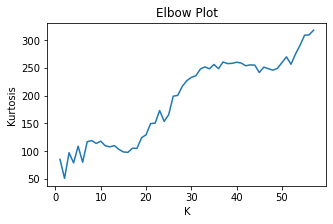

In [88]:
# choose k - kurtosis
scores = {}
for k in range(1, X_ica.shape[1]+1):
    model_lim = model(k, max_iter=50000, random_state=4200)
    X_lim_ica = model_lim.fit_transform(X)
    scores[k] = abs(kurtosis(X_lim_ica)).mean()
choose_k_results['spam_' + method] = scores
elbow_plot(scores, 'Kurtosis')

In [89]:
# choose k
k = 5
alt_k = 23
results.loc[idx, 'k'] = k

In [90]:
# evaluate - reconstruction error
model_lim = model(k, random_state=4200)
X_lim_ica = model_lim.fit_transform(X)
X_lim = model_lim.inverse_transform(X_lim_ica)
diff = X_lim - X
avg_data_error = ((diff ** 2).sum(axis=1) ** .5).mean()
reconstruction_error = (diff ** 2).sum() ** .5
results.loc[idx, 'avg_data_dist_error'] = avg_data_error
results.loc[idx, 'reconstruction_error'] = reconstruction_error
avg_data_error, reconstruction_error

(5.1757762587459855, 392.3694862564285)

In [91]:
model_alt_lim = model(alt_k, random_state=4200)
X_alt_lim_ica = model_alt_lim.fit_transform(X)
X_alt_lim = model_alt_lim.inverse_transform(X_alt_lim_ica)
alt_diff = X_alt_lim - X
avg_data_error = ((alt_diff ** 2).sum(axis=1) ** .5).mean()
reconstruction_error = (alt_diff ** 2).sum() ** .5
avg_data_error, reconstruction_error

(3.7801568193255384, 279.2114488199049)

In [125]:
np.linalg.norm(X)

457.99563316695514

In [93]:
# evaluate - high weighted cols
pd.Series(abs(model_lim.components_).sum(axis=0), index=cols).sort_values(ascending=False).head(10)

word_freq_font                0.010872
char_freq_;                   0.009072
word_freq_1999                0.008839
word_freq_meeting             0.008336
word_freq_original            0.007806
word_freq_you                 0.007633
word_freq_will                0.007632
capital_run_length_longest    0.007616
word_freq_addresses           0.006756
word_freq_our                 0.006685
dtype: float64

In [94]:
# evaluate - low weighted cols
pd.Series(abs(model_lim.components_).sum(axis=0), index=cols).sort_values(ascending=False).tail(10)

char_freq_[             0.002756
word_freq_650           0.002483
word_freq_85            0.002460
word_freq_all           0.002366
word_freq_project       0.002243
word_freq_address       0.002160
word_freq_report        0.002108
word_freq_table         0.001925
word_freq_conference    0.001605
word_freq_3d            0.001558
dtype: float64

In [95]:
# evaluate - low difference in weighted cols
(
    pd.Series(abs(model_lim.components_).sum(axis=0), index=cols) -
    pd.Series(abs(model_orig.components_).sum(axis=0), index=cols)
).abs().sort_values(ascending=False).tail(10)

char_freq_!             0.023039
word_freq_3d            0.022949
word_freq_table         0.022484
word_freq_our           0.022243
word_freq_will          0.022001
word_freq_mail          0.021962
word_freq_conference    0.021931
word_freq_free          0.021572
char_freq_[             0.020755
char_freq_#             0.019187
dtype: float64

In [96]:
# evaluate - high difference in weighted cols
(
    pd.Series(abs(model_lim.components_).sum(axis=0), index=cols) -
    pd.Series(abs(model_orig.components_).sum(axis=0), index=cols)
).abs().sort_values(ascending=False).head(10)

word_freq_857                 0.427701
word_freq_415                 0.361198
word_freq_direct              0.060783
word_freq_technology          0.052906
word_freq_labs                0.051841
word_freq_telnet              0.050666
capital_run_length_longest    0.050050
word_freq_addresses           0.046077
word_freq_650                 0.045689
capital_run_length_total      0.038619
dtype: float64

In [97]:
# evaluate - high squared difference in reconstruction by col
pd.Series((diff ** 2).sum(axis=0), index=cols).abs().sort_values(ascending=False).head(10)

word_freq_3d            3653.797715
word_freq_table         3644.033039
word_freq_conference    3630.889652
word_freq_address       3625.650073
word_freq_report        3582.155903
word_freq_project       3563.247396
word_freq_data          3523.347774
char_freq_[             3499.838102
char_freq_!             3423.800796
char_freq_#             3417.171708
dtype: float64

In [98]:
# evaluate - low squared difference in reconstruction by col
pd.Series((diff ** 2).sum(axis=0), index=cols).abs().sort_values(ascending=False).tail(10)

word_freq_85                  1915.152211
capital_run_length_total      1913.474423
word_freq_650                 1785.675761
word_freq_labs                1213.009243
capital_run_length_longest    1193.562772
word_freq_telnet              1130.439671
word_freq_technology          1114.097761
word_freq_direct               808.464787
word_freq_415                  452.513920
word_freq_857                  446.187014
dtype: float64

#### random projections - spam

In [99]:
X = X_spam_train.copy()
y = y_spam_train.copy()
X_val = X_spam_test.copy()
cols = spam_cols
model = GaussianRandomProjection
idx += 1
method = 'random projections'

In [100]:
results.loc[idx, 'method'] = method

In [101]:
# generate data
model_orig = model(X.shape[1], random_state=4200)
X_rp = model_orig.fit_transform(X)

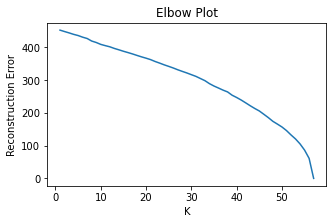

In [102]:
# choose k - reconstruction errora
scores = {}
for k in range(1, X.shape[1]+1):
    W = model_orig.components_[:k].T
    X_rp_k = X.dot(W)
    W_inv = np.linalg.inv(W.T.dot(W)).dot(W.T)
    X_lim = X_rp_k.dot(W_inv)
    error = ((X_lim - X) ** 2).sum() ** .5
    scores[k] = error
choose_k_results['spam_' + method] = scores
elbow_plot(scores, 'Reconstruction Error')

In [103]:
# choose k
k = 10
alt_k = 20
results.loc[idx, 'k'] = k

In [104]:
# evaluate - reconstruction error
model_lim = model(k, random_state=4200)
X_lim_rp = model_lim.fit_transform(X)
W_lim = model_lim.components_.T
W_lim_inv = np.linalg.inv(W_lim.T.dot(W_lim)).dot(W_lim.T)
X_lim = X_lim_rp.dot(W_lim_inv)
diff = X_lim - X
avg_data_error = ((diff ** 2).sum(axis=1) ** .5).mean()
reconstruction_error = (diff ** 2).sum() ** .5
results.loc[idx, 'avg_data_dist_error'] = avg_data_error
results.loc[idx, 'reconstruction_error'] = reconstruction_error
avg_data_error, reconstruction_error

(5.35376927955234, 408.7770370347576)

In [105]:
model_alt_lim = model(alt_k, random_state=4200)
X_alt_lim_rp = model_alt_lim.fit_transform(X)
W_alt_lim = model_alt_lim.components_.T
W_alt_lim_inv = np.linalg.inv(W_alt_lim.T.dot(W_alt_lim)).dot(W_alt_lim.T)
X_alt_lim = X_alt_lim_rp.dot(W_alt_lim_inv)
alt_diff = X_alt_lim - X
avg_data_error = ((alt_diff ** 2).sum(axis=1) ** .5).mean()
reconstruction_error = (alt_diff ** 2).sum() ** .5
avg_data_error, reconstruction_error

(4.7748513153425725, 366.72709851156594)

In [106]:
# evaluate - high weighted cols
pd.Series(abs(model_lim.components_).sum(axis=0), index=cols).sort_values(ascending=False).head(10)

word_freq_business    3.589576
word_freq_internet    3.566498
word_freq_make        3.558950
word_freq_cs          3.314727
word_freq_direct      3.193185
word_freq_your        3.168517
word_freq_address     3.062305
word_freq_will        3.017058
word_freq_1999        2.982692
word_freq_remove      2.941384
dtype: float64

In [107]:
# evaluate - low weighted cols
pd.Series(abs(model_lim.components_).sum(axis=0), index=cols).sort_values(ascending=False).tail(10)

word_freq_650        1.797847
word_freq_hp         1.792771
word_freq_credit     1.758101
word_freq_project    1.727082
word_freq_people     1.524159
word_freq_all        1.474994
word_freq_email      1.469309
word_freq_415        1.405697
word_freq_pm         1.333211
word_freq_receive    1.318263
dtype: float64

In [108]:
# evaluate - low difference in weighted cols
(
    pd.Series(abs(model_lim.components_).sum(axis=0), index=cols) -
    pd.Series(abs(model_orig.components_).sum(axis=0), index=cols)
).abs().sort_values(ascending=False).tail(10)

capital_run_length_total    2.841036
word_freq_parts             2.777776
word_freq_over              2.735371
word_freq_your              2.694007
word_freq_labs              2.662687
word_freq_make              2.605495
word_freq_will              2.466399
word_freq_business          2.425482
word_freq_addresses         2.154339
word_freq_1999              2.041209
dtype: float64

In [109]:
# evaluate - high difference in weighted cols
(
    pd.Series(abs(model_lim.components_).sum(axis=0), index=cols) -
    pd.Series(abs(model_orig.components_).sum(axis=0), index=cols)
).abs().sort_values(ascending=False).head(10)

word_freq_cs            4.593568
word_freq_receive       4.575053
word_freq_people        4.563212
word_freq_mail          4.470700
word_freq_order         4.395231
word_freq_all           4.361527
word_freq_pm            4.350503
word_freq_email         4.306530
word_freq_report        4.256655
word_freq_technology    4.206925
dtype: float64

In [110]:
# evaluate - high squared difference in reconstruction by col
pd.Series((diff ** 2).sum(axis=0), index=cols).abs().sort_values(ascending=False).head(10)

word_freq_415                 3590.270818
word_freq_credit              3580.820626
word_freq_table               3574.988882
word_freq_people              3567.167505
capital_run_length_total      3520.507204
word_freq_all                 3423.175179
word_freq_pm                  3392.881005
word_freq_edu                 3379.290456
word_freq_email               3374.707203
capital_run_length_longest    3339.734907
dtype: float64

In [111]:
# evaluate - low squared difference in reconstruction by col
pd.Series((diff ** 2).sum(axis=0), index=cols).abs().sort_values(ascending=False).tail(10)

word_freq_you           2573.594729
word_freq_remove        2537.129881
word_freq_85            2532.876550
word_freq_cs            2370.356487
word_freq_1999          2241.045455
word_freq_your          2199.807596
word_freq_direct        2065.065647
word_freq_hpl           2015.025732
word_freq_857           1959.061079
word_freq_technology    1816.469160
dtype: float64

#### random forest - spam

In [112]:
X = X_spam_train.copy()
y = y_spam_train.copy()
X_val = X_spam_test.copy()
y_val = y_spam_test.copy()
cols = spam_cols
model = RandomForestClassifier
params = {'max_depth': 5, 'random_state': 4200}
idx += 1
method = 'random forest'

In [113]:
results.loc[idx, 'method'] = method

In [114]:
# generate data
model_orig = model(100, **params)
X_rf = model_orig.fit(X, y)

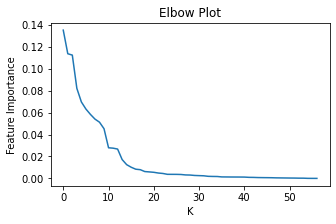

In [115]:
# choose k - feature importance
scores = {}
for k, v in enumerate(sorted(model_orig.feature_importances_, reverse=True)):
    scores[k] = v
choose_k_results['spam_' + method] = scores
elbow_plot(scores, 'Feature Importance')

In [116]:
# choose k
k = 3
alt_k = 10
results.loc[idx, 'k'] = k
sorted_cols = sorted(zip(range(len(cols)), model_orig.feature_importances_), key=lambda x: x[1], reverse=True)
k_cols = [i for i, _ in sorted_cols[:k]]
alt_k_cols = [i for i, _ in sorted_cols[:alt_k]]

In [117]:
# evaluate - model validation
model_lim = model(100, **params)
model_lim.fit(X[:, k_cols], y)
model_lim.score(X_val[:, k_cols], y_val), model_orig.score(X_val, y_val)

(0.8849077090119435, 0.9174809989142236)

In [118]:
model_alt_lim = model(X.shape[1], **params)
model_alt_lim.fit(X[:, alt_k_cols], y)
model_alt_lim.score(X_val[:, alt_k_cols], y_val)

0.9077090119435396

In [119]:
# evaluate - reconstruction error
X_lim = np.zeros(X.shape)
X_lim[:, k_cols] = X[:, k_cols]
diff = X_lim - X
avg_data_error = ((diff ** 2).sum(axis=1) ** .5).mean()
reconstruction_error = (diff ** 2).sum() ** .5
results.loc[idx, 'avg_data_dist_error'] = avg_data_error
results.loc[idx, 'reconstruction_error'] = reconstruction_error
avg_data_error, reconstruction_error

(5.819585226486397, 445.7802149041611)

In [120]:
X_alt_lim = np.zeros(X.shape)
X_alt_lim[:, alt_k_cols] = X[:, alt_k_cols]
alt_diff = X_alt_lim - X
avg_data_error = ((alt_diff ** 2).sum(axis=1) ** .5).mean()
reconstruction_error = (alt_diff ** 2).sum() ** .5
avg_data_error, reconstruction_error

(5.35509758716151, 415.884599378241)

In [121]:
# evaluate - high weighted cols
pd.DataFrame(
    [model_orig.feature_importances_[k_cols], model_lim.feature_importances_],
    columns=pd.Index(cols)[k_cols],
    index=['orig_weight', 'lim_weight']
).T

,orig_weight,lim_weight
char_freq_$,0.135195,0.378201
char_freq_!,0.113674,0.364887
word_freq_remove,0.112421,0.256912


#### save results

In [122]:
results.to_csv('./results/dr_spam.csv', index=False)

In [123]:
for k, v in choose_k_results.items():
    path = f'./results/dr_{k}.csv'
    pd.DataFrame(v, index=[0]).T.to_csv(path)